In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
# 데이터 경로 지정
path2data = './data'
os.makedirs(path2data, exist_ok=True) # 폴더 생성
# MNIST dataset 불러오기
train_ds = datasets.MNIST(path2data, train=True, 
                          transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



5


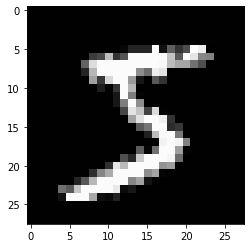

In [3]:
# 샘플 이미지 확인
img, label = train_ds[0]
plt.imshow(to_pil_image(img),cmap='gray')
print(label)

In [4]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)

for x, y in train_dataloader:
  print(x.shape, y.shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [5]:
class Generator(nn.Module):
  def _fc_layer(self, in_channels, out_channels, normalize=True):
      layers=[]
      layers.append(nn.Linear(in_channels, out_channels))
      if normalize:
        layers.append(nn.BatchNorm1d(out_channels, 0.8))
      layers.append(nn.LeakyReLU(0.2))
      return layers
  def __init__(self, params):
    super().__init__()

    self.nz = params['nz']
    self.img_size = params['img_size']
    self.model = nn.Sequential(
        *self._fc_layer(self.nz, 128, normalize=False),
        *self._fc_layer(128, 256),
        *self._fc_layer(256, 512),
        *self._fc_layer(512, 1024),
        nn.Linear(1024, int(np.prod(self.img_size))),
        nn.Tanh()
    )

  def forward(self, z):
      img = self.model(z)
      img = img.view(img.size(0), *self.img_size)
      return img


params = {'nz':100, 'img_size':(1,28,28)}
x = torch.randn(16, 100).to(device)  # random noise
model_gen = Generator(params).to(device)
output = model_gen(x)
print(output.shape)

torch.Size([16, 1, 28, 28])


In [6]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x


x = torch.randn(16, 1, 28, 28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [7]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

## Train

In [8]:
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1 = 0.5
opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [9]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 10

loss_history={'gen':[],
              'dis':[]}

In [10]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [11]:
for epoch in range(num_epochs):
  for xb, yb in train_dataloader:
    ba_si = xb.size(0)
    xb = xb.to(device)
    yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device)
    yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device)

    #Generator
    model_gen.zero_grad()
    noise = torch.randn(ba_si,nz, device=device) # 노이즈 생성
    out_gen = model_gen(noise) # 가짜 이미지 생성
    out_dis = model_dis(out_gen) # 가짜 이미지 판별

    loss_gen = loss_func(out_dis, yb_real)
    loss_gen.backward()
    opt_gen.step()

    #Discriminator
    model_dis.zero_grad()

    out_real = model_dis(xb)
    out_fake = model_dis(out_gen.detach())
    loss_real = loss_func(out_real, yb_real)
    loss_fake = loss_func(out_fake, yb_fake)
    loss_dis = (loss_real + loss_fake) / 2

    loss_dis.backward()
    opt_dis.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())

    batch_count += 1
    if batch_count % 1000 == 0:
        print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' 
              %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 0, G_Loss: 2.230066, D_Loss: 0.398433, time: 0.31 min
Epoch: 1, G_Loss: 4.196043, D_Loss: 0.819964, time: 0.49 min
Epoch: 1, G_Loss: 2.360907, D_Loss: 0.424479, time: 0.68 min
Epoch: 2, G_Loss: 2.619370, D_Loss: 0.457071, time: 0.86 min
Epoch: 2, G_Loss: 0.907967, D_Loss: 0.300419, time: 1.04 min
Epoch: 3, G_Loss: 2.831651, D_Loss: 0.353819, time: 1.22 min
Epoch: 3, G_Loss: 1.032113, D_Loss: 0.321222, time: 1.40 min
Epoch: 4, G_Loss: 4.440019, D_Loss: 0.712929, time: 1.58 min
Epoch: 4, G_Loss: 1.371645, D_Loss: 0.250380, time: 1.77 min
Epoch: 5, G_Loss: 2.559436, D_Loss: 0.093261, time: 1.95 min
Epoch: 5, G_Loss: 2.152394, D_Loss: 0.210905, time: 2.13 min
Epoch: 6, G_Loss: 1.141830, D_Loss: 0.355435, time: 2.31 min
Epoch: 6, G_Loss: 2.792709, D_Loss: 0.258317, time: 2.48 min
Epoch: 7, G_Loss: 2.043579, D_Loss: 0.120972, time: 2.66 min
Epoch: 7, G_Loss: 1.784289, D_Loss: 0.257083, time: 2.84 min
Epoch: 8, G_Loss: 2.009401, D_Loss: 0.167186, time: 3.02 min
Epoch: 9, G_Loss: 1.7983

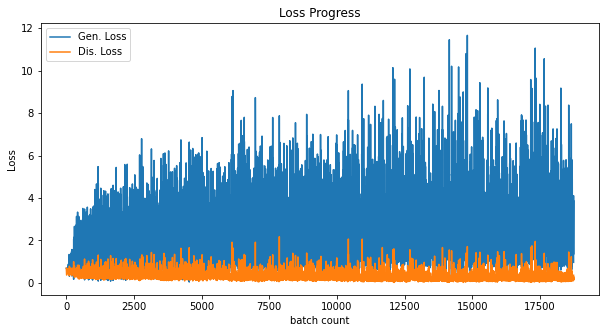

In [14]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Generator 가 생성한 가짜 이미지

torch.Size([16, 1, 28, 28])


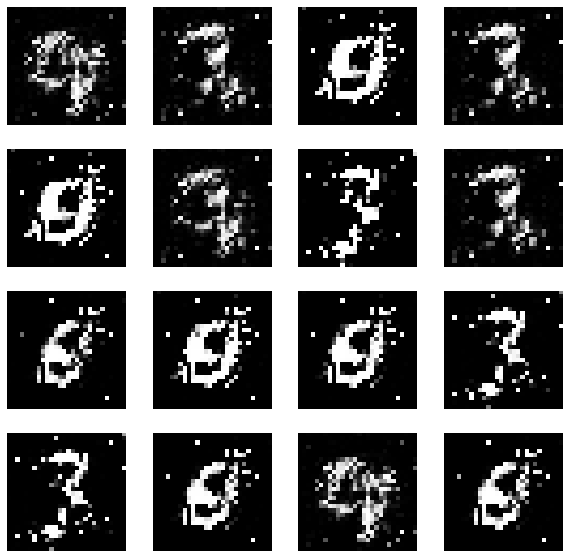

In [16]:
# evaluation mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off')